In [1]:
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm

In [5]:
SOURCE_VIDEO_PATH = "../data/raw/Camera.mp4"

PERSON_DETECTION_MODEL = YOLO("../models/yolo11n.pt")
PERSON_ID = 0

100%|██████████| 5.35M/5.35M [00:01<00:00, 3.31MB/s]


In [3]:
results = PERSON_DETECTION_MODEL.track(SOURCE_VIDEO_PATH, show=True, conf=0.3, tracker="botsort.yaml")

2025-06-03 09:33:42.718 Python[71350:8958643] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/kg/87d0nmxn11xbzs39mwh7hjvr0000gn/T/org.python.python.savedState



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/9000) /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/raw/Camera.mp4: 384x640 17 persons, 1 truck, 776.4ms


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


video 1/1 (frame 2/9000) /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/raw/Camera.mp4: 384x640 17 persons, 1 truck, 601.5ms
video 1/1 (frame 3/9000) /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/raw/Camera.mp4: 384x640 17 persons, 1 truck, 608.3ms
video 1/1 (frame 4/9000) /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/raw/Camera.mp4: 384x640 17 persons, 1 truck, 595.2ms
video 1/1 (frame 5/9000) /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/raw/Camera.mp4: 384x640 17 persons, 1 truck, 584.9ms
video 1/1 (frame 6/9000) /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/raw/Camera.mp4: 384x640 17 persons, 1 truck, 596.8ms
video 1/1 (frame 7/9000) /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/raw/Camera.mp4: 384x640 17 persons, 1 truck, 610.0ms
video 1/1 

KeyboardInterrupt: 

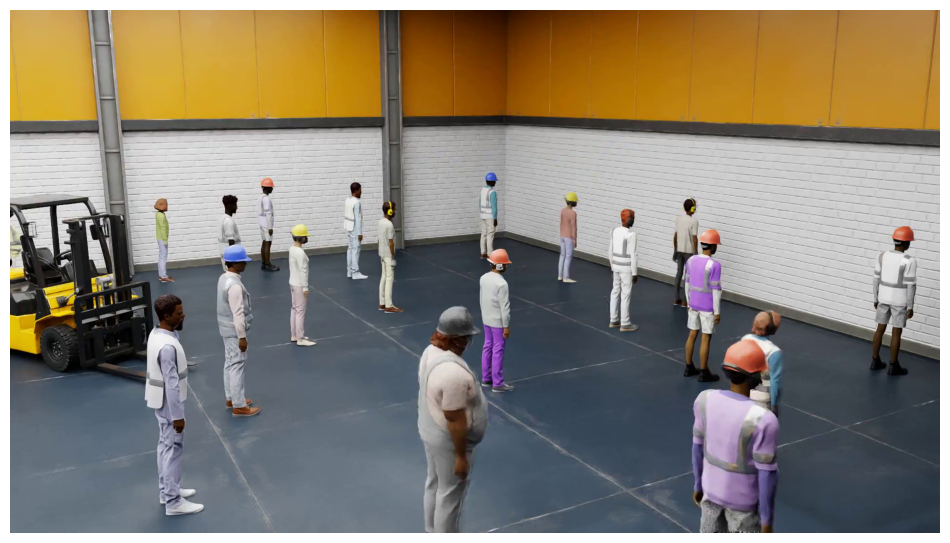

In [3]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [4]:
# box_annotator = sv.BoxAnnotator(
#     color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
#     thickness=2
# )
# label_annotator = sv.LabelAnnotator(
#     color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
#     text_color=sv.Color.from_hex('#000000')
# )

# frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

# result = PERSON_DETECTION_MODEL(frame, task="detect", mode="predict", conf=0.3)[0]
# detections = sv.Detections.from_ultralytics(result)

# labels = [
#     f"{class_name} {confidence:.2f}"
#     for class_name, confidence
#     in zip(detections['class_name'], detections.confidence)
# ]

# annotated_frame = frame.copy()
# annotated_frame = box_annotator.annotate(
#     scene=annotated_frame,
#     detections=detections)
# annotated_frame = label_annotator.annotate(
#     scene=annotated_frame,
#     detections=detections,
#     labels=labels)

# sv.plot_image(annotated_frame)

  0%|          | 0/9000 [00:00<?, ?it/s]


0: 384x640 17 persons, 1 truck, 630.1ms
Speed: 3.6ms preprocess, 630.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


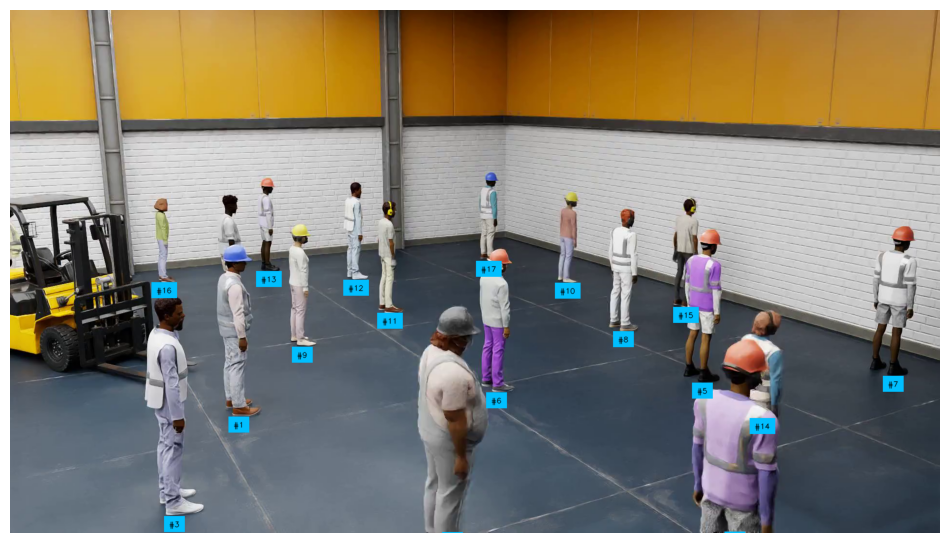

  0%|          | 0/9000 [00:01<?, ?it/s]


In [9]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = PERSON_DETECTION_MODEL(frame, task="detect", mode="predict", conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    all_detections = detections[detections.class_id == PERSON_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    # all_detections.class_id -= 1
    all_detections = tracker.update_with_detections(detections=all_detections)

    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    annotated_frame = frame.copy()
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels
    )

    sv.plot_image(annotated_frame)
    break